# Shapley Value Approximation

## Data Acquisition 

In [10]:
import numpy as np

import sklearn as sk
from sklearn import *

from pydvl.utils import Dataset, Utility
from pydvl.utils import Dataset
from pydvl.reporting.plots import plot_shapley
from pydvl.utils.dataset import GroupedDataset
from pydvl.value import *

import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf

dataset = Dataset.from_sklearn(datasets.load_iris())
model = neighbors.KNeighborsClassifier(n_neighbors=3)
utility = Utility(model, dataset)
n = utility.data.x_train.shape[0]

In [11]:
# dataset = Dataset.from_sklearn(datasets.load_diabetes())
# model = linear_model.LogisticRegression()
# utility = Utility(model, dataset)
# n = utility.data.x_train.shape[0]

## Truncated Monte Carlo Approximation

In [12]:
tmc_values = compute_shapley_values(
    utility,
    mode = ShapleyMode.TruncatedMontecarlo,
    # Stop if the standard error is below 1% of the range of the values (which is ~2),
    # or if the number of updates exceeds 1000
    done=AbsoluteStandardError(threshold=0.05, fraction=0.9) | MaxUpdates(1000),
    truncation=RelativeTruncation(utility, rtol=0.001),
    n_jobs=-1,
)
#values.sort(key="value")
tmc_shapley_value = tmc_values.to_dataframe(column="data_value", use_names=True)

In [13]:
tmc_shapley_value

,data_value,data_value_stderr,data_value_updates
0,0.000000,0.00000,5
1,0.000000,0.00000,5
2,0.000000,0.00000,5
3,0.093333,0.08348,5
4,0.000000,0.00000,5
...,...,...,...
115,0.000000,0.00000,5
116,0.000000,0.00000,5
117,0.000000,0.00000,5
118,0.000000,0.00000,5


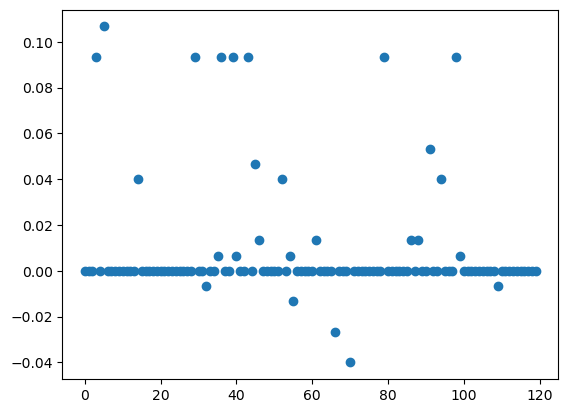

In [14]:
plt.scatter(range(n),tmc_shapley_value.data_value)
plt.show()

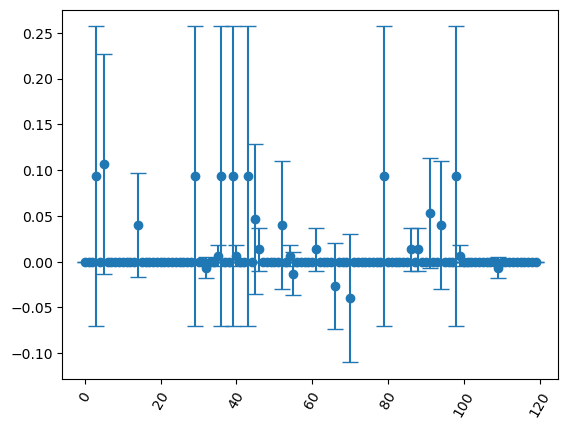

In [15]:
plot_shapley(tmc_shapley_value)
plt.show()

## Beta Shapley Value

In [16]:
ValuationResult = compute_beta_shapley_semivalues(
    u=utility,
    alpha=1,
    beta=1,
    done=AbsoluteStandardError(threshold=0.05, fraction=0.9) | MaxUpdates(1000),
    sampler_t=PermutationSampler,
    batch_size=128,
    n_jobs=1
)

PermutationSampler requires caching to be enabled or computation will be doubled wrt. a 'direct' implementation of permutation MC


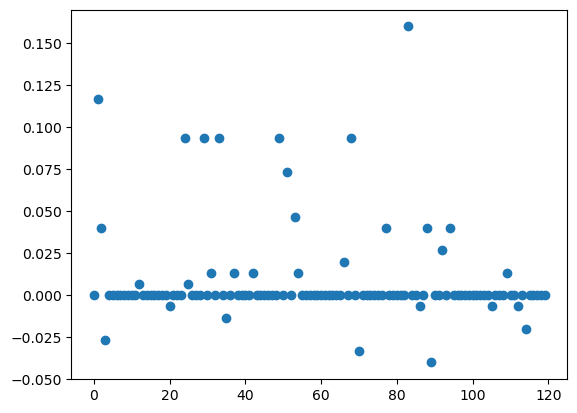

In [17]:
beta_result = ValuationResult.to_dataframe(column="data_value", use_names=True)
plt.scatter(range(n),beta_result.data_value)
plt.show()

## CS Shapley Value

## Owen Sampling

## KNN SV

In [18]:
dataset = Dataset.from_sklearn(datasets.load_diabetes())
model = sk.neighbors.KNeighborsClassifier(n_neighbors=3)
utility = Utility(model, dataset)

In [19]:
knn_result = knn_shapley(utility,progress=True)
knn_result = knn_result.to_dataframe(column="data_value", use_names=True)


89it [00:00, 654.73it/s]


In [20]:
plt.scatter(range(len(knn_result.data_value)),knn_result.data_value)
plt.show()

: 

## Compresive SV

In [21]:
import numpy as np
import cvxpy as cp
from concurrent.futures import ThreadPoolExecutor

def compute_phi(i, utility, permutation):
    """ 计算数据点 i 的边际贡献 phi。 """
    U_with_i = utility(permutation[:i + 1])  # 加入i后的效用
    U_without_i = utility(permutation[:i])     # 未加入i时的效用
    return U_with_i - U_without_i

def compressive_permutation_sampling(utility, M, T):
    """
    压缩感知置换采样计算Shapley Value.
    
    参数：
    utility - 可调用对象，负责对训练数据子集重新训练并计算效用
    M - 伯努利矩阵A的行数，压缩感知测量数
    T - 随机置换次数
    
    返回：
    训练集中每个数据点的Shapley Value估计
    """
    N = len(utility.data.x_train)  # 数据点个数
    
    # 生成伯努利矩阵A
    A = np.random.choice([-1/np.sqrt(M), 1/np.sqrt(M)], size=(M, N))
    
    y_hat = np.zeros((M, T))
    
    for t in range(T):
        print(f"Iteration: {t+1}/{T}")
        
        permutation = np.random.permutation(N)
        
        phi_t = np.zeros(N)
        
        # 使用ThreadPoolExecutor并行计算phi_t
        with ThreadPoolExecutor() as executor:
            futures = {executor.submit(compute_phi, i, utility, permutation): i for i in range(N)}
            for future in futures:
                i = futures[future]
                phi_t[i] = future.result()
        
        # 对每个m，计算y_hat[m, t]
        for m in range(M):
            y_hat[m, t] = np.dot(A[m, :], phi_t)
    
    y_bar = np.mean(y_hat, axis=1)
    
    U_D = utility(permutation)  # 整个数据集的效用
    s_bar = U_D / N
    
    delta_s = cp.Variable(N)  # 定义变量 delta_s
    epsilon = 1e-6  # 允许的误差范围
    
    # 目标：最小化 L1 范数 ||Δs||_1
    objective = cp.Minimize(cp.norm1(delta_s))
    
    # 约束：||A(s_bar + Δs) - y_bar||_2 <= epsilon
    constraints = [cp.norm2(A @ (s_bar + delta_s) - y_bar) <= epsilon]
    
    # 定义并求解优化问题
    problem = cp.Problem(objective, constraints)
    problem.solve()

    if problem.status in ["infeasible", "unbounded"]:
        print("优化失败！返回初始估计。")
        delta_s_value = np.zeros(N)
    else:
        delta_s_value = delta_s.value

    # 最终Shapley Value估计
    s_hat = s_bar + delta_s_value
    return s_hat

# 参数设置
M = 5  # 压缩感知测量数
T = 100
# 计算Shapley Value
cp_shapley_values = compressive_permutation_sampling(utility, M, T)

print("Shapley Values:", cp_shapley_values)
plt.scatter(range(n),cp_shapley_values)
plt.show()

Iteration: 1/100
Iteration: 2/100
Iteration: 3/100


## Gradient SV

In [ ]:
from DShap import DShap
model = 'logistic'
problem = 'classification'
num_test = 1000
directory = './temp'
dshap = DShap(utility.data.x_train.astype(float), 
              utility.data.y_train.astype(int), 
              utility.data.x_test.astype(float), 
              utility.data.y_test.astype(int), 
              num_test, 
              sources=None, 
              sample_weight=None,
              model_family=model, 
              metric='accuracy',
              overwrite=True,
              directory=directory, seed=0)
dshap.run(100, 0.1, g_run=True)
dshap.run(100, 0.1, g_run=False,loo_run=False)
dshap.merge_results()
dshap.marginals_g
tmc = np.mean(dshap.marginals_tmc,0)
plt.scatter(range(n),tmc)
plt.show()

g_sv = np.mean(dshap.marginals_g,0)
plt.scatter(range(n),g_sv)
plt.show()